In [42]:
# %matplotlib widget
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ccf_utils import ccf_pts_convert_to_mm
from utils.ephys_functions import*
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
import spikeinterface as si
from trimesh import load_mesh
import k3d
import matplotlib.cm as cm
%matplotlib inline


In [59]:
def pir_to_lps(points):
    """
    Convert point(s) from PIR to LPS.
    points: shape (3,) or (N, 3) array-like in PIR order.
    Returns: same shape in LPS.
    """
    pts = np.asarray(points)
    M = np.array([[ 0,  0, -1],   # x_lps = -z_pir
                  [ 1,  0,  0],   # y_lps =  x_pir
                  [ 0, -1,  0]])  # z_lps = -y_pir
    if pts.ndim == 1:
        return M @ pts
    return pts @ M.T

def lps_to_pir(points):
    """
    Convert point(s) from LPS to PIR.
    points: shape (3,) or (N, 3) array-like in LPS order.
    Returns: same shape in PIR.
    """
    pts = np.asarray(points)
    M = np.array([[0,  1,  0],   # x_pir =  y_lps
                  [0,  0, -1],   # y_pir = -z_lps
                  [-1, 0,  0]])  # z_pir = -x_lps
    if pts.ndim == 1:
        return M @ pts
    return pts @ M.T


def make_ccf_tbl(animal_id, annotator = 'zs', data_type = 'curated', save_to_session = True):
    annotation_dir = f'/root/capsule/data/alignment_{annotator}/{animal_id}'
    if os.path.exists(annotation_dir) == False:
        print('No annotation directory found')
    dorsal_edge_json = f'/root/capsule/data/dorsal_edges/{animal_id}_dorsal_edge_ccf.json'
    if os.path.exists(dorsal_edge_json):
        with open(dorsal_edge_json, 'r') as f:
            dorsal_edge_dict = json.load(f)
        # make into a dataframe
        dorsal_edge_df = pd.DataFrame(dorsal_edge_dict['xyz_picks'], columns=['x', 'y', 'z'])
        # make into a dataframe
        dorsal_edge_df['x'] = -dorsal_edge_df['x']/1000
        dorsal_edge_df['y'] = -dorsal_edge_df['y']/1000
        dorsal_edge_df['z'] = dorsal_edge_df['z']/1000

    # grab all session ids for this animal
    session_list_annotation = os.listdir(annotation_dir)
    date_list_annotation = [parseSessionID(session)[1] for session in session_list_annotation]
    session_assets = pd.read_csv('/root/capsule/code/data_management/session_assets.csv')
    session_list_all = session_assets['session_id']
    session_list_animal = [session for session in session_list_all if isinstance(session, str)]
    session_list_animal = [session for session in session_list_animal if animal_id in session]
    date_list_animal = [parseSessionID(session)[1] for session in session_list_animal]

    # for each date_list, find the corresponding session in session_list_all within 1 minute tolerance
    session_list = []
    for date in date_list_annotation:
        time_diff = [abs((date_list_animal_curr - date).total_seconds()) for date_list_animal_curr in date_list_animal]
        min_ind = np.argmin(time_diff)
        if time_diff[min_ind] < 60:
            session_list.append(session_list_animal[min_ind])
        else:
            session_list.append(None)
    
    unit_tbls = []
    probe_tbls = []
    for session_ind in range(len(session_list)):
        if session_list[session_ind] is None:
            print(f'No matching session found for {session_list_annotation[session_ind]}')
            unit_tbls.append(None)
            probe_tbls.append(None)    
        else:
            print(f'Processing {session_list_annotation[session_ind]} matched to {session_list[session_ind]}')
            session = session_list[session_ind]
            session_annotation = session_list_annotation[session_ind]
            session_dir = session_dirs(session_id=session)
            sorting_analyzer = si.load(session_dir[f'postprocessed_dir_{data_type}'], load_extensions=False)
            channel_locations = sorting_analyzer.get_channel_locations()
            unit_locations = sorting_analyzer.get_extension("unit_locations").get_data()
            channel_ids = sorting_analyzer.channel_ids
            channel_num = [int(chan[2:]) for chan in channel_ids]
            unit_loc_along_probe = unit_locations[:, 1]
            channel_loc_along_probe = channel_locations[:, 1]
            ccf_location_file = os.path.join(annotation_dir, session_annotation, 'ProbeA/ccf_channel_locations.json')
            ccf_dict = json.load(open(ccf_location_file, 'r'))
            ccf_df = pd.DataFrame(ccf_dict).T
            ccf_df.index = ccf_df.index.astype(str)  # make sure index is string
            ccf_df["channel_ind"] = ccf_df.index.str.split("_").str[1].astype(int)
            # filter by if channel_ind in channel_num
            ccf_df = ccf_df[ccf_df["channel_ind"].isin(channel_num)]
            ccf_df["loc_along_probe"] = channel_loc_along_probe
            # x for ml, y for ap, z for dv, with ccf origin and scale of mm
            xp = pd.to_numeric(ccf_df['loc_along_probe'], errors='raise').to_numpy()
            fp_x = pd.to_numeric(ccf_df['x'], errors='raise').to_numpy()
            fp_y = pd.to_numeric(ccf_df['y'], errors='raise').to_numpy()
            fp_z = pd.to_numeric(ccf_df['z'], errors='raise').to_numpy()

            unit_x_ccf = np.interp(unit_loc_along_probe, xp, fp_x)
            unit_y_ccf = np.interp(unit_loc_along_probe, xp, fp_y)
            unit_z_ccf = np.interp(unit_loc_along_probe, xp, fp_z)
            unit_ccf_df = pd.DataFrame({'unit_id': sorting_analyzer.unit_ids,
                                    'x_ccf': unit_x_ccf,
                                    'y_ccf': unit_y_ccf,
                                    'z_ccf': unit_z_ccf,
                                    'loc_along_probe': unit_loc_along_probe})
            unit_tbl = get_unit_tbl(session, data_type)
            unit_tbl = unit_tbl.drop(columns=['x_ccf', 'y_ccf', 'z_ccf'], errors="ignore")
            if save_to_session:
                save_dir = os.path.join(session_dir[f'ephys_processed_dir_{data_type}'],'ccf_unit_locations.csv')
                unit_ccf_df.to_csv(save_dir, index=False)
            unit_tbl_combined = unit_tbl.merge(unit_ccf_df, left_on='unit_id', right_on='unit_id', how='left')
            corr = unit_tbl_combined['corr_max_p'].values
            corr[np.isnan(corr)] = 1
            unit_tbl_combined = unit_tbl_combined[(unit_tbl_combined['decoder_label']!='noise') & (unit_tbl_combined['decoder_label']!='artifact') & (corr>0.85)]
            probe_tbls.append(ccf_df)
            unit_tbls.append(unit_tbl_combined)



    norm = Normalize(vmin=0, vmax=1)
    ml, ap, dv = 0, 1, 2
    planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
    if os.path.exists(dorsal_edge_json):
        dorsal_edge_mat = dorsal_edge_df.values

    mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
    mesh_vertices = np.array(mesh.vertices)
    mesh_vertices = (mesh_vertices - np.array([216, 18, 228]))*25/1000
    mesh_vertices_lps = pir_to_lps(mesh_vertices) # convert to lps

    # add the other side
    mesh_vertices_mm_flipped = mesh_vertices_lps.copy()
    mesh_vertices_mm_flipped[:, ml] = -mesh_vertices_mm_flipped[:, ml]
    mesh_vertices_mm = np.vstack([mesh_vertices_lps, mesh_vertices_mm_flipped])
    colormaps = ['Reds', 'Greens', 'Blues', 'Oranges', 'Greys']

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    import matplotlib.cm as cm
    import matplotlib.patches as mpatches
    for plane, ax in zip(planes.keys(), axes):
        # Plot the mesh
        ax.scatter(
            mesh_vertices_mm[:, planes[plane][0]],
            mesh_vertices_mm[:, planes[plane][1]],
            color='gray', alpha=0.5, s=0.005,
            edgecolors=None
        )

        # plot dorsal edge if exists
        if os.path.exists(dorsal_edge_json):
            ax.scatter(
                dorsal_edge_mat[:, planes[plane][0]],
                dorsal_edge_mat[:, planes[plane][1]],
                color='b', s=1,
                edgecolors=None
            )

        # Plot the points
        for session_ind, session in enumerate(session_list):
            unit_tbl_combined = unit_tbls[session_ind]
            unit_tbl_combined = unit_tbl_combined.sort_values(by="p_max", ascending=True)
            ccfs = unit_tbl_combined[['x_ccf', 'y_ccf', 'z_ccf']].values
            bregma_LPS_mm = np.array([-5.7, 5.4, -0.45])  # in mm
            ccfs = ccfs - bregma_LPS_mm

            # for probe
            ccfs_probe = probe_tbls[session_ind][['x', 'y', 'z']].values
            ccfs_probe = ccfs_probe - bregma_LPS_mm
            sc = ax.scatter(
                ccfs_probe[:, planes[plane][0]], 
                ccfs_probe[:, planes[plane][1]], 
                color='k', 
                s=5, 
                edgecolors=None,
                linewidth=0.2
                )
            sc = ax.scatter(
                ccfs[:, planes[plane][0]],
                ccfs[:, planes[plane][1]],
                c=unit_tbl_combined['p_max'],
                cmap=colormaps[session_ind],
                s=50, alpha=0.3,
                edgecolors=None, linewidths=1,
            )
            sort_ind = np.argsort(ccfs[:, dv])
            
            # ax.plot(ccfs[sort_ind, planes[plane][0]], ccfs[sort_ind, planes[plane][1]], color=cm.get_cmap(colormaps[session_ind])(1.0), label=session, linewidth=0.5)

        ax.set_xlabel(planes[plane][0])
        ax.set_ylabel(planes[plane][1])
        ax.set_aspect('equal')

    # add the legend with brightest color for each session

    legend_handles = []
    for session_ind, session in enumerate(session_list):
        cmap = cm.get_cmap(colormaps[session_ind])
        brightest = cmap(1.0)  # lowest value = brightest in Reds/Greens/Blues
        patch = mpatches.Patch(color=brightest, label=session)
        legend_handles.append(patch)

    axes[1].legend(handles=legend_handles, title="Sessions")


    axes[0].invert_yaxis()
    axes[0].invert_xaxis()
    axes[2].invert_yaxis()


    plt.suptitle(f'{animal_id} units in CCF space with max(P(spike|laser)) color coding')
    plt.tight_layout()
    plt.savefig(f'/root/capsule/scratch/combined/ccf_maps/{animal_id}_{annotator}_units_ccf_opto_tag.png', dpi=300)


    colormaps = ['Reds', 'Greens', 'Blues', 'Oranges', 'Greys']

    # --- Load and preprocess mesh ---


    # Convert mesh to k3d mesh
    vertices = mesh_vertices_mm.astype(np.float32)
    indices = np.array(mesh.faces, dtype=np.uint32)

    plot = k3d.plot(camera_auto_fit=True)

    plt_mesh = k3d.mesh(
        vertices=vertices,
        indices=indices,
        color=0x888888,   # gray mesh
        opacity=0.1,
        wireframe=False,
        name='LC_right'
    )

    vertices_flipped = vertices.copy()
    vertices_flipped[:, ml] = -vertices_flipped[:, ml]

    plt_mesh_flipped = k3d.mesh(
        vertices=vertices_flipped,
        indices=indices,
        color=0x888888,   # gray mesh
        opacity=0.1,
        wireframe=False,
        name='LC_left'
    )

    plot += plt_mesh
    plot += plt_mesh_flipped

    # add dorsal edge if exists
    if os.path.exists(dorsal_edge_json):
        plt_dorsal = k3d.points(
            positions=dorsal_edge_mat.astype(np.float32),
            point_size=0.02,
            color=0x0000FF,   # blue points
            shader="3d",
            name='Dorsal_edge'
        )
        plot += plt_dorsal

    # --- Add probes + units for each session ---
    for session_ind, session in enumerate(session_list):
        unit_tbl_combined = unit_tbls[session_ind].sort_values(by="p_max", ascending=True)

        # Units
        ccfs = unit_tbl_combined[['x_ccf', 'y_ccf', 'z_ccf']].values
        ccfs = ccfs - bregma_LPS_mm

        # Probes
        ccfs_probe = probe_tbls[session_ind][['x', 'y', 'z']].values
        ccfs_probe = ccfs_probe - bregma_LPS_mm

        # Colormap based on p_max
        cmap = cm.get_cmap(colormaps[session_ind])
        colors = (cmap(unit_tbl_combined['p_max'].values)[:, :3] * 255).astype(np.uint32)
        colors = (colors[:,0] << 16) + (colors[:,1] << 8) + colors[:,2]

        # Units
        plt_units = k3d.points(
            positions=ccfs.astype(np.float32),
            point_size=0.05,
            colors=colors,
            opacity=0.4,
            shader="3d",
            name=f'Units_{session[9:]}'
        )
        plot += plt_units

        # Probes (black points)
        plt_probes = k3d.points(
            positions=ccfs_probe.astype(np.float32),
            point_size=0.02,
            color=0x000000,
            shader="3d",
            name=f'Probe_{session[9:]}'
        )
        plot += plt_probes
    # save a html file
    # --- Save interactive plot to HTML ---
    html_file = f'/root/capsule/scratch/combined/ccf_maps/{animal_id}_{annotator}_units_ccf_plot.html'
    with open(html_file, 'w') as f:
        f.write(plot.get_snapshot())

    plot.display()

Processing behavior_782394_2025-04-23_10-51-14 matched to behavior_782394_2025-04-23_10-51-17
Processing behavior_782394_2025-04-22_10-53-22 matched to behavior_782394_2025-04-22_10-53-28
Processing behavior_782394_2025-04-25_11-13-18 matched to behavior_782394_2025-04-25_11-13-21
Processing behavior_782394_2025-04-24_12-07-31 matched to behavior_782394_2025-04-24_12-07-34


/tmp/ipykernel_1055871/3760295866.py:196: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormaps[session_ind])
/tmp/ipykernel_1055871/3760295866.py:273: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormaps[session_ind])
/tmp/ipykernel_1055871/3760295866.py:273: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormaps[session_ind])
/tmp/ipykernel_1055871/3760295866.py:273: MatplotlibDeprecationWarning: T

Output()

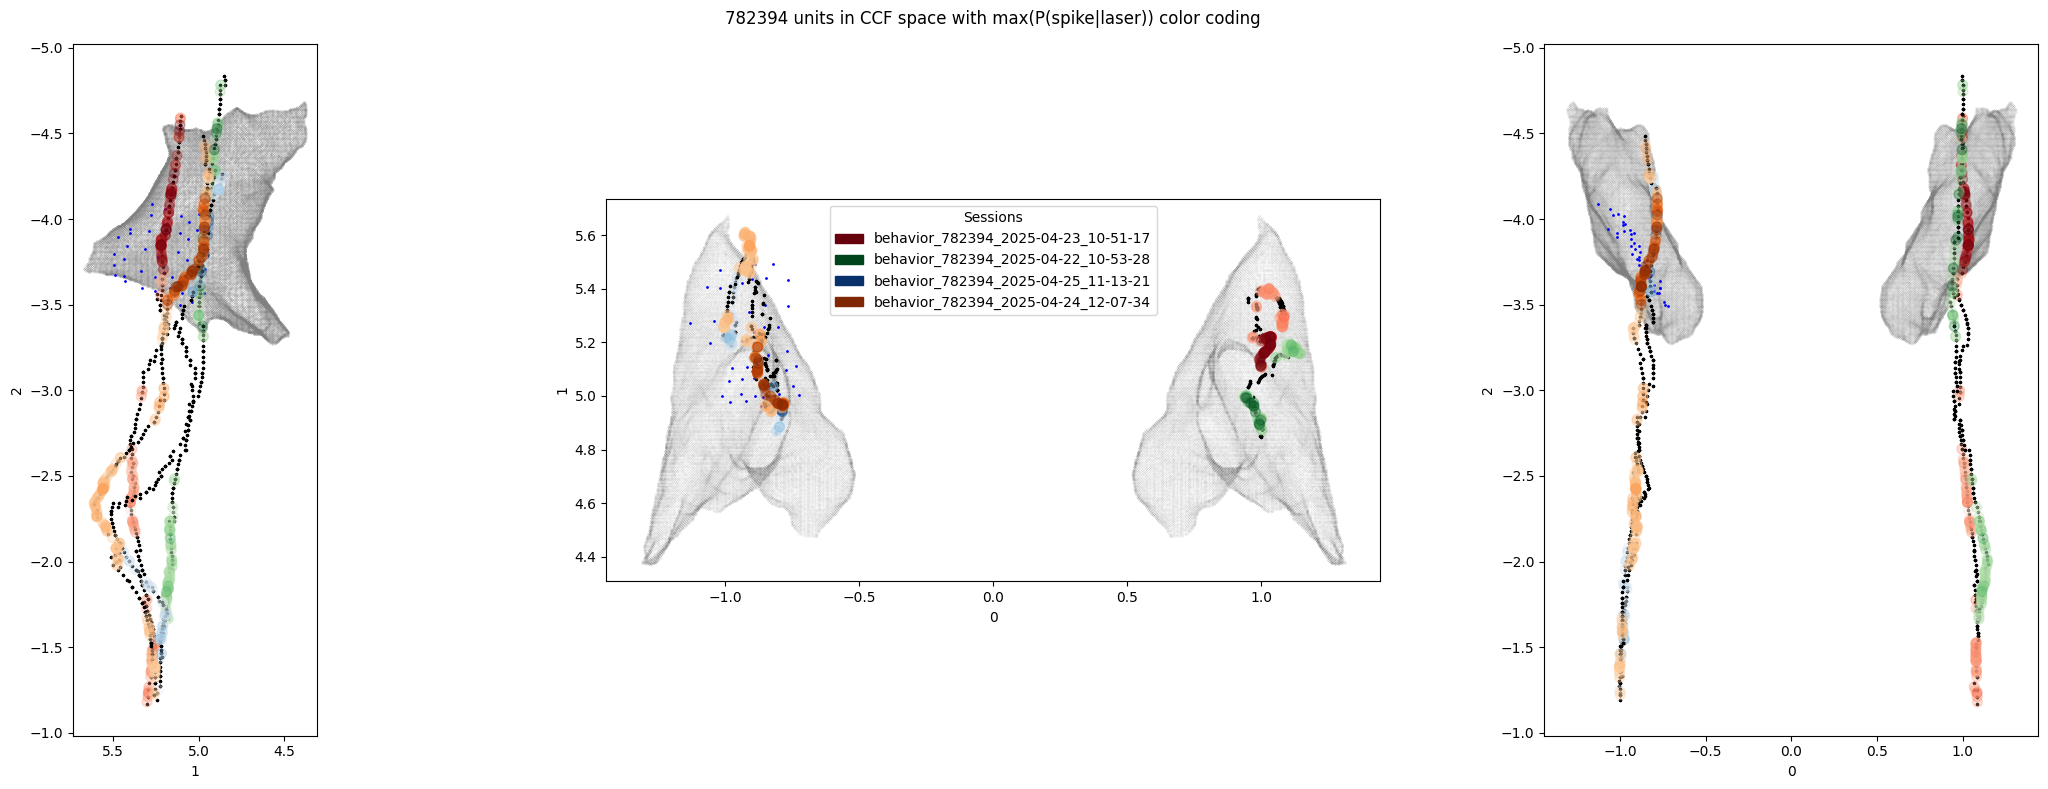

In [61]:
make_ccf_tbl('782394', annotator='zs', data_type='curated', save_to_session=True)

In [39]:
unit_tbl_combined = get_unit_tbl('behavior_782394_2025-04-24_12-07-34', 'curated')

In [45]:
animal_id = '782394'
dorsal_edge_json = f'/root/capsule/data/dorsal_edges/{animal_id}_dorsal_edge_ccf.json'
if os.path.exists(dorsal_edge_json):
    with open(dorsal_edge_json, 'r') as f:
        dorsal_edge_dict = json.load(f)
# make into a dataframe
dorsal_edge_df = pd.DataFrame(dorsal_edge_dict['xyz_picks'], columns=['x', 'y', 'z'])
dorsal_edge_df['x'] = -dorsal_edge_df['x']/1000
dorsal_edge_df['y'] = -dorsal_edge_df['y']/1000

In [46]:
dorsal_edge_df

,x,y,z
0,1068.891846,-5404.708862,-3942.714279
1,785.761200,-4971.369171,-3567.770355
2,1019.019257,-5470.984650,-3895.593613
3,722.991882,-5004.607391,-3490.193909
4,745.023285,-5039.013672,-3518.196838
5,867.386566,-4961.377716,-3706.730240
6,1130.457245,-5273.953247,-4089.223450
7,932.726227,-5493.994904,-3794.308060
8,1018.086182,-5404.150391,-3919.656342
9,981.140839,-4978.358459,-3968.209427


In [3]:
# plot all session with p_response in space
all_brains = ['751766', '752014', '754897', '758017', '758018', '761038', '782394', '784803', '784806', '785956', '791691']
all_sessions = pd.read_csv('/root/capsule/code/data_management/session_assets.csv')['session_id'].to_list()
all_sessions = [
    session for session in all_sessions 
    if isinstance(session, str) and any(brain in session for brain in all_brains)
]


In [26]:
ml, ap, dv = 2, 0, 1
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
dorsal_edge_mat = dorsal_edge_df.values[:, [1, 2, 0]]/1000
dorsal_edge_mat[:, dv] = -dorsal_edge_mat[:, dv]

No unit table found for behavior_751766_2025-02-15_12-08-11 in curated data.
No unit table found for behavior_784803_2025-07-03_13-55-13 in curated data.


/tmp/ipykernel_395218/643736684.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_ccfs_tbl = pd.concat(all_ccfs_tbls, ignore_index=True)


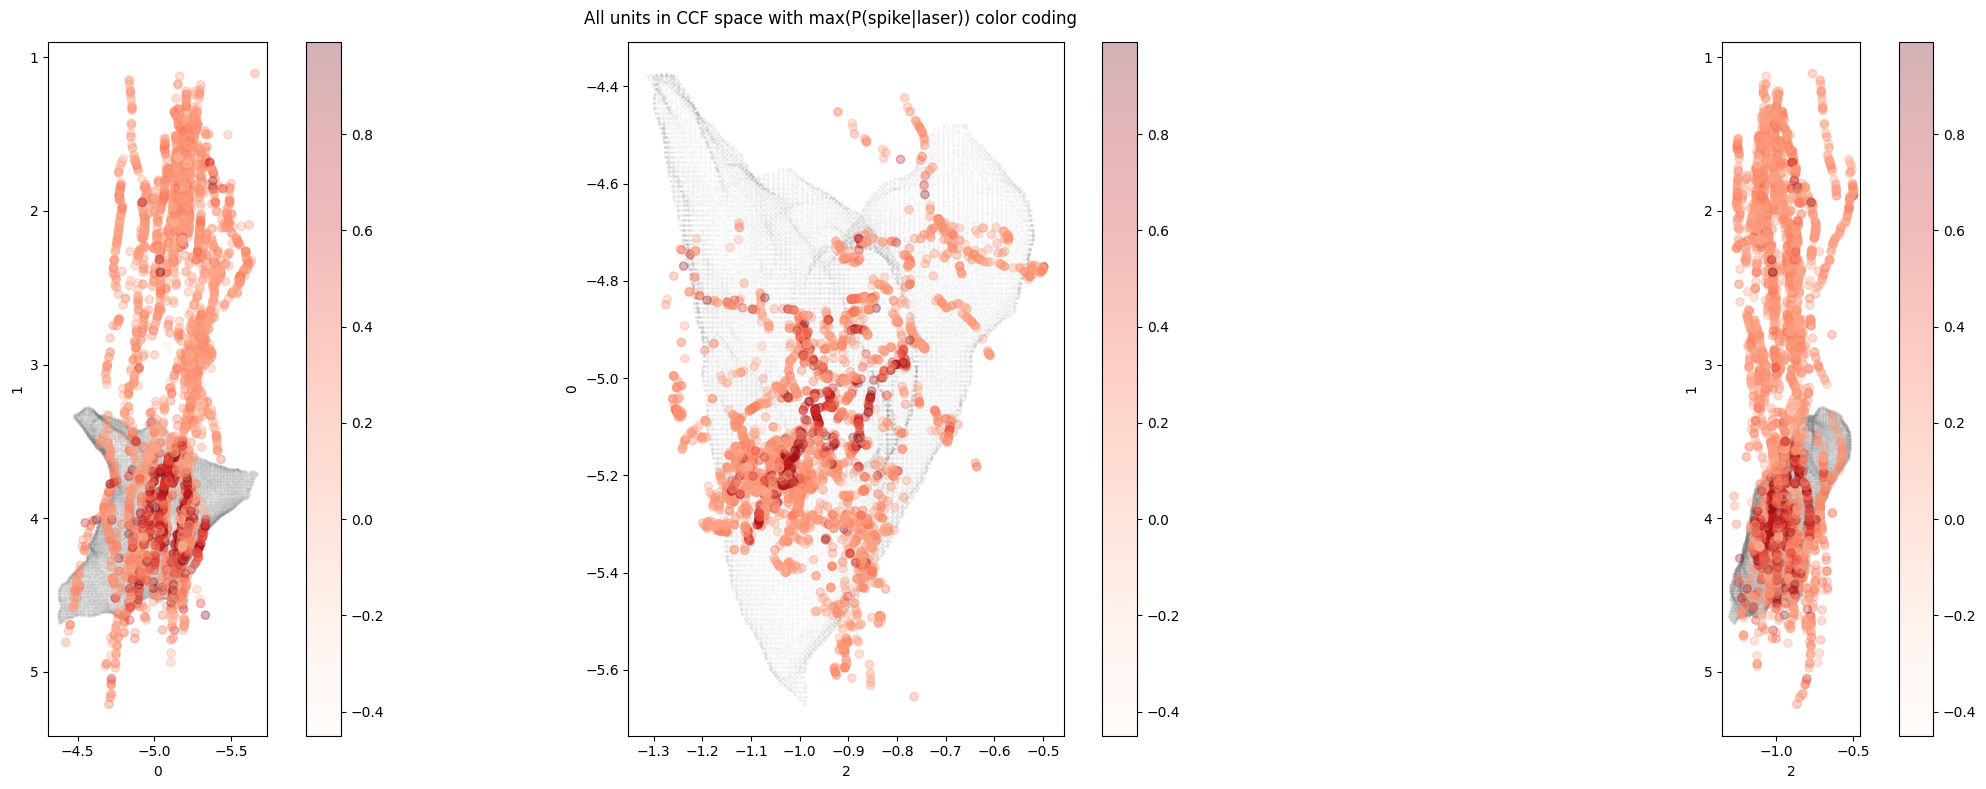

In [4]:
all_ccfs_tbls = []
for session in all_sessions:
    unit_tbl = get_unit_tbl(session, data_type='curated')
    if unit_tbl is not None:
        corr = unit_tbl['corr_max_p'].values
        corr[np.isnan(corr)] = 1
        unit_tbl_filtered = unit_tbl[(unit_tbl['decoder_label']!='noise') & (unit_tbl['decoder_label']!='artifact') & (corr>0.85)]
        all_ccfs_tbls.append(unit_tbl_filtered)
all_ccfs_tbl = pd.concat(all_ccfs_tbls, ignore_index=True)

# --- Load and preprocess mesh ---
norm = Normalize(vmin=0, vmax=1)
ml, ap, dv = 2, 0, 1
planes = {'sag': [ap, dv], 'hor': [ml, ap], 'cor': [ml, dv]}
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')

mesh_vertices = np.array(mesh.vertices)
mesh_vertices_mm = ccf_pts_convert_to_mm(mesh_vertices)

# add the other side
mesh_vertices_mm_flipped = mesh_vertices_mm.copy()
mesh_vertices_mm_flipped[:, ml] = -mesh_vertices_mm_flipped[:, ml]

# Plot the points
x_ccf = -all_ccfs_tbl['x_ccf'].values / 25 * 1000
y_ccf = all_ccfs_tbl['y_ccf'].values / 25 * 1000
z_ccf = -all_ccfs_tbl['z_ccf'].values / 25 * 1000
ccfs = np.column_stack((y_ccf, z_ccf, x_ccf))
ccfs = ccf_pts_convert_to_mm(ccfs)
ccfs[ccfs[:, ml]>0, ml] = -ccfs[ccfs[:, ml]>0, ml]
# mesh_vertices_mm = np.vstack([mesh_vertices_mm, mesh_vertices_mm_flipped])
colormaps = ['Reds', 'Greens', 'Blues', 'Oranges', 'Greys']

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
import matplotlib.cm as cm
import matplotlib.patches as mpatches
for plane, ax in zip(planes.keys(), axes):
    # Plot the mesh
    ax.scatter(
        mesh_vertices_mm[:, planes[plane][0]],
        mesh_vertices_mm[:, planes[plane][1]],
        color='gray', alpha=0.5, s=0.005,
        edgecolors=None
    )

    sc = ax.scatter(
        ccfs[:, planes[plane][0]],
        ccfs[:, planes[plane][1]],
        c=all_ccfs_tbl['p_max'],
        cmap='Reds',
        s=35, alpha=0.3,
        edgecolors=None, linewidths=1,
    )
    # add colorbar
    cbar = plt.colorbar(sc, ax=ax)
    # sort_ind = np.argsort(ccfs[:, dv])
    
    # ax.plot(ccfs[sort_ind, planes[plane][0]], ccfs[sort_ind, planes[plane][1]], color=cm.get_cmap(colormaps[session_ind])(1.0), label=session, linewidth=0.5)

    ax.set_xlabel(planes[plane][0])
    ax.set_ylabel(planes[plane][1])
    ax.set_aspect('equal')

# add the legend with brightest color for each session


axes[0].invert_yaxis()
axes[0].invert_xaxis()
axes[2].invert_yaxis()


plt.suptitle(f'All units in CCF space with max(P(spike|laser)) color coding')
plt.tight_layout()
plt.savefig(f'/root/capsule/scratch/combined/ccf_maps/all_units_ccf_opto_tag.png', dpi=300)
plt.show()


In [27]:
import numpy as np
import k3d
from matplotlib import cm
from matplotlib.colors import Normalize

# --- Normalize colormap based on p_max ---
norm = Normalize(vmin=all_ccfs_tbl['p_max'].min(), vmax=all_ccfs_tbl['p_max'].max())
cmap = cm.get_cmap('Reds')

# --- Load and convert mesh ---
ml, ap, dv = 2, 0, 1
mesh = load_mesh('/root/capsule/scratch/combined/ccf_maps/20250418_transformed_remesh_10_ccf25.obj')
mesh_vertices = np.array(mesh.vertices)
mesh_vertices_mm = ccf_pts_convert_to_mm(mesh_vertices)

# Add mirrored hemisphere
mesh_vertices_mm_flipped = mesh_vertices_mm.copy()
mesh_vertices_mm_flipped[:, ml] = -mesh_vertices_mm_flipped[:, ml]
# mesh_vertices_mm = np.vstack([mesh_vertices_mm, mesh_vertices_mm_flipped])

# --- Prepare unit coordinates ---
x_ccf = -all_ccfs_tbl['x_ccf'].values / 25 * 1000
y_ccf = all_ccfs_tbl['y_ccf'].values / 25 * 1000
z_ccf = -all_ccfs_tbl['z_ccf'].values / 25 * 1000
ccfs = np.column_stack((y_ccf, z_ccf, x_ccf))
ccfs = ccf_pts_convert_to_mm(ccfs)
ccfs[ccfs[:, ml] > 0, ml] = -ccfs[ccfs[:, ml] > 0, ml]


# Colormap based on p_max
cmap = cm.get_cmap('Reds')
colors = (cmap(all_ccfs_tbl['p_max'].values)[:, :3] * 255).astype(np.uint32)
colors = (colors[:,0] << 16) + (colors[:,1] << 8) + colors[:,2]

# --- Create k3d plot ---
plot = k3d.plot(background_color=0xffffff, grid_visible=False, axes_helper=0)

# Add semi-transparent mesh (gray)
plot += k3d.points(
    positions=mesh_vertices_mm.astype(np.float32),
    colors=np.full(mesh_vertices_mm.shape[0], 0x808080, dtype=np.uint32),
    point_size=0.02,
    opacity=0.15
)

# Add dorsal edge (blue)
dorsal_edge_mm = dorsal_edge_mat.copy()
dorsal_edge_mm[:, ml] = -dorsal_edge_mm[:, ml]
plot += k3d.points(
    positions=dorsal_edge_mm.astype(np.float32),
    colors=np.full(dorsal_edge_mm.shape[0], 0x0000ff, dtype=np.uint32),
    point_size=0.05,
    opacity=0.8
)

# Add unit points, colored by p_max
plot += k3d.points(
    positions=ccfs.astype(np.float32),
    colors=colors,
    point_size=0.03,
    shader='3d'
)

# save as html
html_file = f'/root/capsule/scratch/combined/ccf_maps/all_units_ccf_plot.html'
with open(html_file, 'w') as f:
    f.write(plot.get_snapshot())
# --- Display ---
plot.display()


/tmp/ipykernel_395218/712458028.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')
/tmp/ipykernel_395218/712458028.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


Output()

(array([ 1.,  2.,  3.,  6.,  3.,  2.,  2.,  4.,  4.,  5.,  2.,  4.,  6.,
         6.,  2.,  0.,  5.,  2.,  3.,  1.,  4.,  3.,  8.,  9.,  7., 13.,
         9.,  6.,  4.,  2.,  6.,  7.,  4.,  5.,  2.,  9.,  3.,  2.,  1.,
         5.,  1.,  2.,  0.,  1.,  3.,  1.,  1.,  1.,  0.,  1.]),
 array([3299.22444153, 3317.93372345, 3336.64300537, 3355.35228729,
        3374.06156921, 3392.77085114, 3411.48013306, 3430.18941498,
        3448.8986969 , 3467.60797882, 3486.31726074, 3505.02654266,
        3523.73582458, 3542.44510651, 3561.15438843, 3579.86367035,
        3598.57295227, 3617.28223419, 3635.99151611, 3654.70079803,
        3673.41007996, 3692.11936188, 3710.8286438 , 3729.53792572,
        3748.24720764, 3766.95648956, 3785.66577148, 3804.37505341,
        3823.08433533, 3841.79361725, 3860.50289917, 3879.21218109,
        3897.92146301, 3916.63074493, 3935.34002686, 3954.04930878,
        3972.7585907 , 3991.46787262, 4010.17715454, 4028.88643646,
        4047.59571838, 4066.30500031

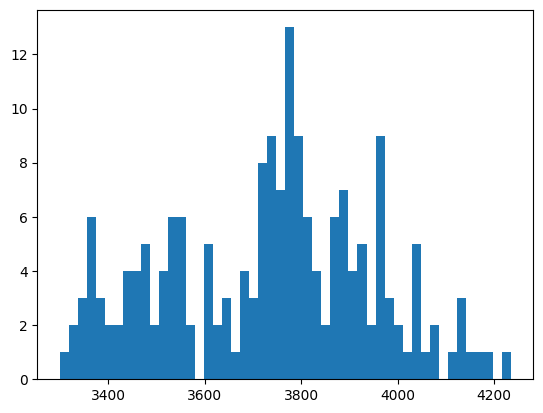

In [25]:
# plt.hist(ccfs[:, dv], bins=50)
plt.hist(dorsal_edge_mat[:, dv], bins=50)

In [17]:
pip install k3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 84.9 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [k3d]3/4 [k3d]
Note: you may need to restart the kernel to use updated packages.
